In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json

In [2]:
torch.manual_seed(123)

# Simplest version of k-Armed Bandit problem

In [3]:
class ArmedBandit:
    '''
    Simplest version of k-armed bandit problem.
    Actions - from 1 to k.
    Action values q[a] - normal random.
    Reward disribution is normal with mean q[a] and unit variance
    Action value estimates Q[a] are sample averages.
    Policy - eps-greedy, UCB
    '''

    def __init__(self, k, Q_0 = 0.):

        self.k = k
        
        # init action values
        self.q = torch.randn(k)
        self.a_opt = (self.q == self.q.max()).nonzero() # 2d tensor, each row is index of opt action

        # init value estimates and counts
        self.Q = Q_0 * torch.ones(k, dtype = torch.float32)
        self.N = torch.zeros(k, dtype = torch.long)

        # logs
        self.history = {'actions' : [], 'rewards' : [], 'mean_rewards' : []} 

    def _sample_reward(self, a, std = 1):
        # Sample reward for action a
        return (self.q[a] + std * torch.randn(1)).item()


#-----------Policy algorithms--------------------------------
    def _eps_greedy_policy(self, eps = 0.1):
        max_indices = torch.nonzero(self.Q == self.Q.max()).flatten()
        
        # compute probabilities for choosing actions with epsilon greedy policy
        pi = (eps / self.k) * torch.ones(self.k)
        pi[max_indices] += (1-eps) / len(max_indices)

        return torch.multinomial(pi, 1).item()
    
    def _greedy_policy(self):
        return self._eps_greedy_policy(eps = 0)

    def _UCB_policy(self, p, c = 2**(-0.5)):
        '''
        Upper Confidence Bound policy
        p - probability of reward outside confidence bound.
        '''
        # When the count is zero N[a] = 0, the action 'a' is considered optimal. Therefore we assign it float('inf') value.
        Q_U = torch.where(
            self.N != 0, 
            self.Q + c * ( -torch.tensor(p).log() / self.N )**0.5,
            float('inf')
            )
        max_indices = (Q_U == Q_U.max()).nonzero().flatten()
        perm = torch.randperm(len(max_indices))
        return max_indices[perm[0]].item()

    def _gradient_bandit_policy(self, logits):
        pi = logits.softmax(dim = 0)
        a = torch.multinomial(pi, 1).item()
        return a, pi

#-----------------------------------------------------------------    

    def play(self, t, policy, logs = True, **kwargs):
        '''
        t       - total play time
        policy  - function that returns action a, such as _greedy_policy
        kwargs  - policy hyperparams: 
            'eps_greedy'        - eps 
            'UCB'               - c 
            'gradient_bandit'   - alpha
        '''

        if policy == 'gradient_bandit':
            logits = torch.zeros(self.k, dtype = torch.float32)

        R_mean = 0 # running average reward per time step
        for i in range(t):
            # sample action a according to policy and update count N[a]
            # sample reward
            # update value estimate Q[a] or policy params (e.g. logits in gradient bandit)

            if policy == 'greedy':
                a = self._greedy_policy()
            
            elif policy == 'eps_greedy':
                a = self._eps_greedy_policy(**kwargs)

            elif policy == 'UCB':
                a = self._UCB_policy(1/(i+1), **kwargs)

            elif policy == 'gradient_bandit':
                a, pi = self._gradient_bandit_policy(logits)


            self.N[a] += 1

            R = self._sample_reward(a)
            R_mean += (1/(i+1)) * (R - R_mean)
            
            

            if policy in ['greedy', 'eps_greedy', 'UCB']:
                self.Q[a] += (1/self.N[a]) * (R - self.Q[a])

            elif policy == 'gradient_bandit':
                kroneker_a = torch.zeros(self.k)
                kroneker_a[a] = 1
                logits += kwargs['alpha'] * (R - R_mean) * (kroneker_a - pi)


            # logs
            if logs:
                self.history['actions'].append(a)
                self.history['rewards'].append(R)
                self.history['mean_rewards'].append(R_mean)

## Single game runs

**Play one game with greedy policy**

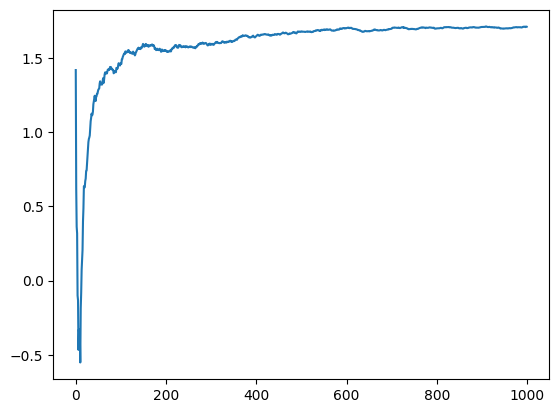

In [81]:
game = ArmedBandit(10)
game.play(1000, 'greedy')
plt.plot(game.history['mean_rewards'])

**Play one game with epsilon-greedy policy**

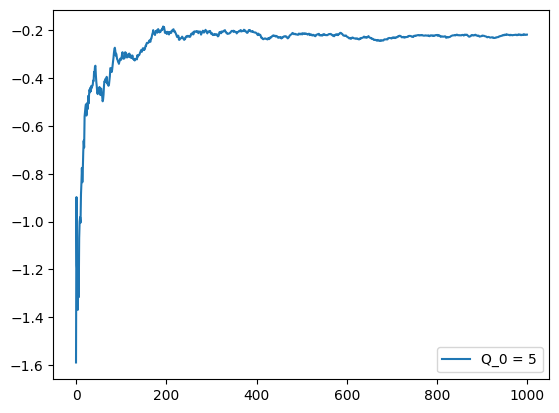

In [82]:
game_eps = ArmedBandit(k, Q_0 = 5)
game_eps.play(1000, 'eps_greedy', eps = 0.1)

plt.plot(game_eps.history['mean_rewards'], label = 'Q_0 = 5')
plt.legend()
plt.show()

**One game with UCB policy**

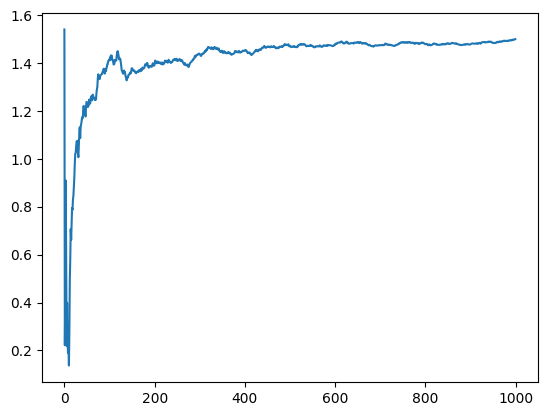

In [83]:
game_UCB = ArmedBandit(k)
game_UCB.play(1000, 'UCB', c = 0.1)

plt.plot(game_UCB.history['mean_rewards'])
plt.show()

**One game with gradient ascent policy learning**

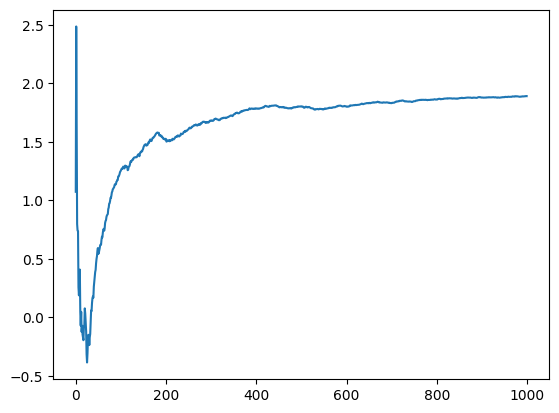

In [95]:
game = ArmedBandit(k, Q_0 = 5)
game.play(1000, 'gradient_bandit', alpha = 0.1)

plt.plot(game.history['mean_rewards'])
plt.show()

## Average stats over many runs

In [4]:
def many_runs(num_games, k, t, algorithm, **kwargs):

    games = [ArmedBandit(k) for _ in range(num_games)]
    
    for game in tqdm(games):
        game.play(t, algorithm, **kwargs)

    return games

In [8]:
def compute_average_stats(games, stationary = True):
    
    R_mean = torch.stack( [torch.tensor(game.history['mean_rewards']) for game in games] ).mean(dim = 0)

    # compute running ratio of optimal actions to all actions

    opt_action_frac = 0
    for game in tqdm(games):

        if stationary:
            is_opt_action = torch.tensor([a in game.a_opt for a in game.history['actions']])
        else:
            try: # fast computation, if optimal actions at each time step are unique
                a_opt = torch.stack(game.history['opt_actions']).view(-1)
                a = torch.tensor(game.history['actions'])
                is_opt_action = (a_opt == a)
            except:
                is_opt_action = [a in a_opt for a, a_opt in zip(game.history['actions'], game.history['opt_actions'])]
                is_opt_action = torch.tensor(is_opt_action)


        num_a_opt = is_opt_action.cumsum(dim = 0)
        steps = torch.arange(1, len(num_a_opt)+1, dtype = torch.float32)
        
        opt_action_frac += num_a_opt / steps

    opt_action_frac /= len(games)

    return R_mean, opt_action_frac

In [6]:
def plot_average_stats(games_collection, labels, stationary = True):
    fig, axs = plt.subplots(2,1, sharex = True)
    axs[0].set_ylabel('Average reward')

    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Optimal action ratio')

    for games, label in zip(games_collection, labels):
        R_mean, opt_action_frac = compute_average_stats(games, stationary)

        axs[0].plot(R_mean, label = label)
        axs[1].plot(opt_action_frac, label = label)
    
    axs[0].legend()
    plt.tight_layout()
    plt.show()


In [ ]:
k = 10
t = 1000
num_runs = 500

games_greedy = many_runs(num_runs, k, t, 'greedy')
games_eps1 = many_runs(num_runs, k, t, 'eps_greedy', eps = 0.01)
games_eps2 = many_runs(num_runs, k, t, 'eps_greedy', eps = 0.1)

In [440]:
games_collection = [games_greedy, games_eps1, games_eps2]
labels = ['eps = 0 (greedy)', 'eps = 0.01', 'eps = 0.1']

**Save runs**

In [441]:
# data = [labels, games_collection]
# torch.save(data, 'stationary_bandit_data')

We can load precomputed stats

In [4]:
labels, games_collection = torch.load('stationary_bandit_data')

**Plot results, either from runs or saved data**

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

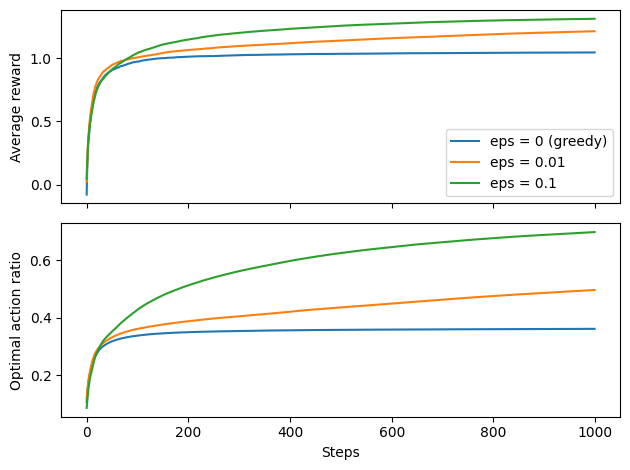

In [9]:
plot_average_stats(games_collection, labels)

**The plots look very similar to figure 2.2 in Sutton-Barto. Epsilon-greedy policy is doing better than greedy. Exploration helps!**

# Nonstationary k-Armed Bandit

In [20]:
# This class solves Exercises 2.5, 2.11 in Sutton-Barto. 

class NonStationaryArmedBandit(ArmedBandit):
    '''
    The reward distirubtion is changing at every time step, unlike in ArmedBandit.
    This is modeled by a random walk for q.
    '''

    def __init__(self, k, Q_0 = 0., rand_walk_var = 0.01, alpha_Q = None):

        super().__init__(k, Q_0)

        # overwrite values q to be the same for all actions
        self.q = torch.ones(k) * torch.randn(1)

        self.rand_walk_var = rand_walk_var
        self.alpha_Q = alpha_Q     # step-size param for updating action-value estimate Q. Defaults to sample-averaging, else use const step-size alpha

        # init history for optimal actions, that are now nonstationary
        self.history['opt_actions'] = []
        self.history['mean_reward'] = 0

    # overwrite play
    def play(self, t, 
            policy, 
            logs = True, 
            log_mean_reward = False, 
            mean_reward_start = 0, 
            **kwargs):
        '''
        t               - play time
        policy          - function that returns action a, such as _greedy_policy
        logs            - bool, whether to log actions, opt_actions, rewards, mean_rewards. Useful to save memory on long runs.
        log_mean_reward      - bool, whether to track mean reward so far, starting from time step log_mean_reward_start
        log_mean_reward_start - time step from which to start tracking total reward
        
        kwargs          - policy hyperparams: 
            'eps_greedy'        - eps 
            'UCB'               - c 
            'gradient_bandit'   - alpha
        '''


        if policy == 'gradient_bandit':
            logits = torch.zeros(self.k, dtype = torch.float32)
        
        R_mean = 0 # running average reward per time step
        if log_mean_reward:
            self.history['mean_reward_start'] = mean_reward_start

        
        for i in range(t):

            # random walk for reward distributions
            self.q += self.rand_walk_var * torch.randn(self.k)
            # record new optimal action
            a_opt = (self.q == self.q.max()).nonzero() # 2d tensor; each row is (1,) tensor index of optimal action. 

            # The rest is essentially the same as in ArmedBandit, except for step-size param alpha

            if policy == 'eps_greedy':
                a = self._eps_greedy_policy(**kwargs)
            
            elif policy == 'greedy':
               a = self._greedy_policy()
            
            elif policy == 'UCB':
                a = self._UCB_policy(1/(i+1), **kwargs)

            elif policy == 'gradient_bandit':
                a, pi = self._gradient_bandit_policy(logits)
            
            
            self.N[a] += 1

            R = self._sample_reward(a)
            R_mean += (1/(i+1)) * (R - R_mean)
    

            if policy in ['eps_greedy', 'greedy', 'UCB']:
                alpha_Q = self.alpha_Q if self.alpha_Q is not None else 1/self.N[a]    # default to sample averaging if alpha_Q is None
                self.Q[a] += alpha_Q * (R - self.Q[a])

            elif policy == 'gradient_bandit':
                kroneker_a = torch.zeros(self.k)
                kroneker_a[a] = 1
                logits += kwargs['alpha'] * (R - R_mean) * (kroneker_a - pi)
            
            

            # logs
            if logs:
                self.history['actions'].append(a)
                self.history['opt_actions'].append(a_opt)
                self.history['rewards'].append(R)
                self.history['mean_rewards'].append(R_mean)
            
            if log_mean_reward and i >= mean_reward_start:
                self.history['mean_reward']  +=  (1/(i-mean_reward_start+1)) * (R - self.history['mean_reward'])


## One game runs

**To check the code, run one non-stationary game with sample-averaging**

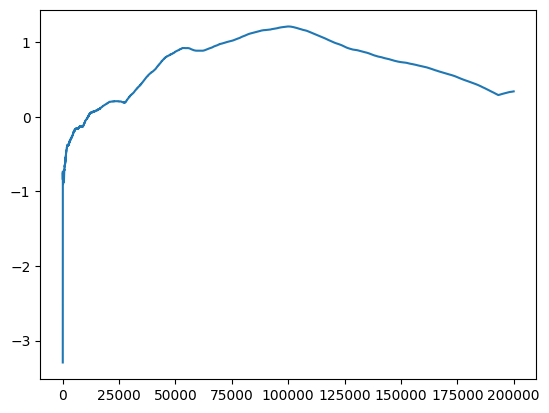

In [65]:
k = 10
t = 200000

nonstat_game = NonStationaryArmedBandit(k)
nonstat_game.play(t, 'eps_greedy', eps = 0.1)

plt.plot(nonstat_game.history['mean_rewards'])
plt.show()

**And one nonstationary game with exp-weighted averaging**

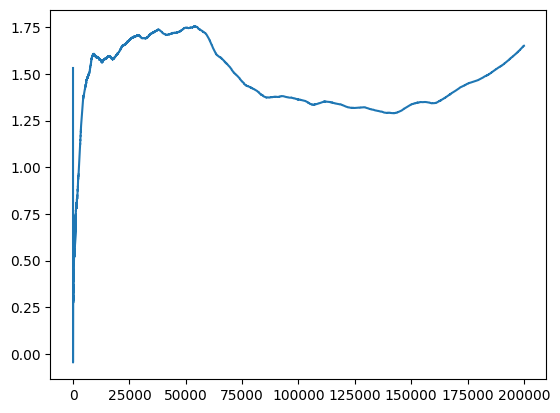

In [64]:
k = 10
t = 200000

nonstat_game = NonStationaryArmedBandit(k, alpha_Q = 0.1)
nonstat_game.play(t, 'eps_greedy', eps = 0.1)

plt.plot(nonstat_game.history['mean_rewards'])
plt.show()

**One game with UCB and exp-averaging**

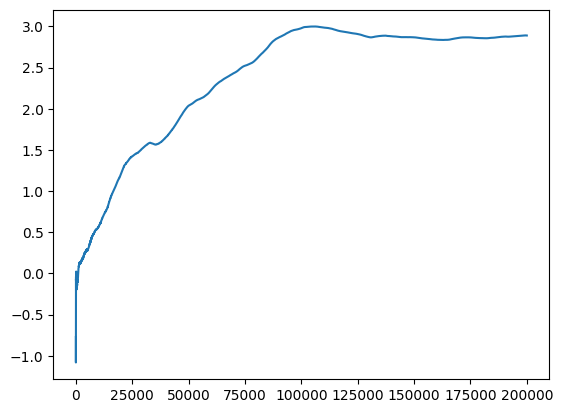

In [103]:
k = 10
t = 200000

nonstat_game = NonStationaryArmedBandit(k, alpha_Q = 0.1)
nonstat_game.play(t, 'UCB', c = 0.1)

plt.plot(nonstat_game.history['mean_rewards'])
plt.show()

In [155]:
k = 10
t = 200000

nonstat_game = NonStationaryArmedBandit(k, alpha_Q = 0.1)
nonstat_game.play(t, 'gradient_bandit',
                    logs = False,
                    log_mean_reward = True,
                    mean_reward_start = 0,
                    alpha = 0.1)

nonstat_game.history

{'actions': [],
 'rewards': [],
 'mean_rewards': [],
 'opt_actions': [],
 'mean_reward': 3.6592174423679,
 'mean_reward_start': 0}

## Average stats over many runs

In [368]:
def many_runs_nonstationary(num_games, k, t, algorithm, alpha = None, **kwargs):

    games = [NonStationaryArmedBandit(k, alpha = alpha) for _ in range(num_games)]
    
    for game in tqdm(games):
        game.play(t, algorithm, **kwargs)

    return games

**Let's run non-stationary k-armed bandit with sample-averaging**

In [ ]:
k = 10
t = 100000
num_runs = 100

games_sample_ave = many_runs_nonstationary(num_runs, k, t, 'eps_greedy', eps = 0.1)

**And with constant step-size, i.e. exponentially-weighted averaging for action value estimates Q**

In [ ]:
games_exp_ave = many_runs_nonstationary(num_runs, k, t, 'eps_greedy', alpha = 0.1, eps = 0.1)

In [447]:
games_collection = [games_sample_ave, games_exp_ave]
labels = ['Sample-averaging', 'Exp-weighted averaging']

This data is roughly 4.5GB, so we do not save it

**Plot averaged results**

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

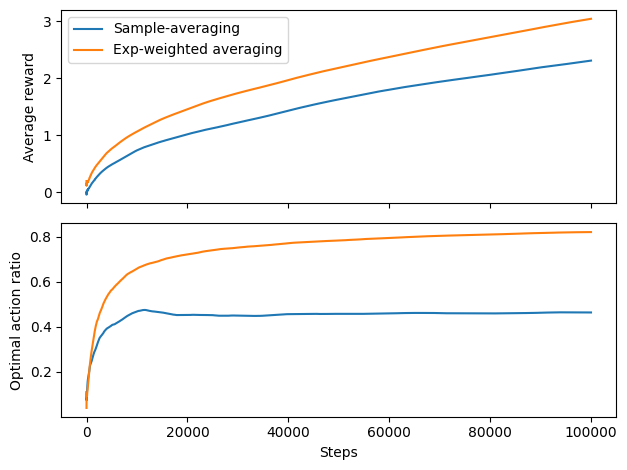

In [395]:
plot_average_stats(games_collection, labels, stationary = False)

**Exp-weighted averaging handles nonstationary problem much better, as expected.**

## Parameter study for various policies

**Exercise 2.11**

We compute performance of various k-armed bandit algorithms

In [130]:
@torch.no_grad()
def many_runs(num_games, k, t, policy, Q_0=0., alpha_Q = None, mean_reward_start = 0, **kwargs):
    
    games = [NonStationaryArmedBandit(k, Q_0 = Q_0, alpha_Q = alpha_Q) for _ in range(num_games)]
    R_mean = 0

    for game in tqdm(games, leave = False):
        game.play(t, policy,
                    logs = False,
                    log_mean_reward = True,
                    mean_reward_start = mean_reward_start,
                    **kwargs)
        
        R_mean += game.history['mean_reward']
    
    R_mean /= num_games

    return R_mean

**Epsilon-greedy**: $\epsilon$ - probability that a random non-greedy action is chosen

$$
\pi(a) = \begin{cases} 
            {1 - \epsilon \over n_{opt}} + {\epsilon \over k} \ , \qquad \ \text{if} \quad  a = \argmax_a Q(a) \\
            {\epsilon \over k}                                \ , \qquad \qquad \quad \text{otherwise}
           \end{cases}
$$
where k - number of available actions, n_{opt} - number of optimal actions.

**Upper-confidence bound**: c - coefficent for the uncertainty of value estimate (see formula 2.10 in Sutton-Barto)

$$A_t = \argmax_a \left( Q_t(a) + c \sqrt{\log t \over N_t(a)} \right)$$

**Gradient ascent policy learning**: $\alpha$ - update step parameter in gradient ascent for preferences (see (2.12) in SB)

$$
H_{t+1}(a) = H_t(a) + \alpha (R_t - \bar R_t)(\delta_{a = A_t} - \pi_t(a))
$$
where $A_t$ is the action chosen on time step $t$.

**Greedy with optimistic initialization**: $Q_0$ - value estimate initialization for all actions. (The default value in all other algorithms is $Q_0 = 0$.)

In [177]:
policies = {
            'eps_greedy'        : [ {'eps'  : 2**i }  for i in range(-13, -1) ], 
            'UCB'               : [ {'c'    : 2**i }  for i in range(-5, 10) ], 
            'gradient_bandit'   : [ {'alpha': 2**i }  for i in range(-4, 9) ], 
            'greedy' : [ {'Q_0'  : 2**i }  for i in range(6, 9) ]
            }

policies

{'gradient_bandit': [{'alpha': 1.52587890625e-05},
  {'alpha': 3.0517578125e-05},
  {'alpha': 6.103515625e-05}]}

In [27]:
k = 10
t = 200000
num_games = 100
mean_reward_start = 100000

reward_ave = {}
params = {}

In [ ]:
for policy, kwargs_list in policies.items():
    
    reward_ave[policy] = []
    params[policy] = []

    for kwargs in tqdm(kwargs_list):
        r = many_runs(num_games, k, t, policy, alpha_Q = 0.1, mean_reward_start = mean_reward_start, **kwargs)
        
        print(r)
        reward_ave[policy].append(r)
        
        for v in kwargs.values():
            params[policy].append(v)


In [212]:
# with open('mean_rewards.json', 'w') as f:
#     json.dump((params, reward_ave), f)

The computation above takes a long time. I have precomputed them and one can load saved stats

In [214]:
with open('mean_rewards.json', 'r') as f:
    params, reward_ave = json.load(f)

In [226]:
params_names = {
            'eps_greedy'        : r'$\epsilon$', 
            'UCB'               : '$c$', 
            'gradient_bandit'   : r'$\alpha$', 
            'greedy'            : '$Q_0$'
            }

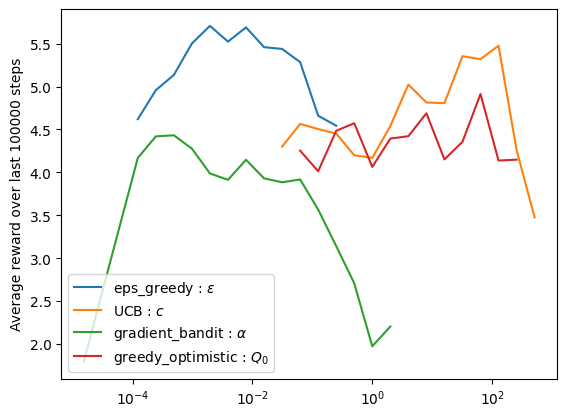

In [227]:
for policy in reward_ave:
    plt.plot(params[policy], reward_ave[policy], 
            label = (policy if policy != 'greedy' else 'greedy_optimistic') + ' : ' + params_names[policy])
plt.xscale('log')
plt.ylabel('Average reward over last 100000 steps')
plt.legend()
plt.show()